In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools as it

import gpflow
import gpflow.multikernels as mk

In [2]:
X = np.random.rand(100)[:, None] * 10 - 5
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])
Y = np.matmul(G, Ptrue)
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

In [3]:
def plot_model(m):
    pX = np.linspace(-6, 6, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_color_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

# MixedMultiOutput kernel -- Independent inducing points

In [4]:
M = 20
K = 3
L = 2
q_mu = np.zeros((M, L))
q_sqrt = np.tile(np.eye(M)[None, :, :], [L, 1, 1])
with gpflow.defer_build():
    kern = mk.MixedMultiKernel([gpflow.kernels.RBF(1) + gpflow.kernels.Linear(1) for _ in range(L)], P=Ptrue.T)
    feature = mk.MixedMultiIndependentFeature(Z=X[:M, :].copy())
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), feature)
    m.q_mu = gpflow.params.Parameter(q_mu, dtype=gpflow.settings.float_type)
    m.q_sqrt = gpflow.params.Parameter(q_sqrt, dtype=gpflow.settings.float_type)
m.compile()

In [5]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=30000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 23.508862
  Number of iterations: 10463
  Number of functions evaluations: 11177


In [6]:
m.compute_log_likelihood()

-23.508861703718814

/home/vincent/.virtualenvs/gpflow/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


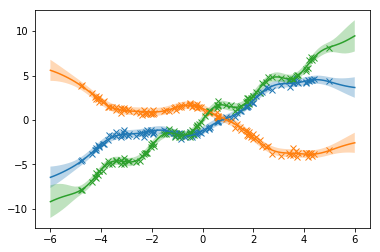

In [7]:
plot_model(m)

In [8]:
pX = tf.identity(np.linspace(-6, 6, 100)[:, None])
for cov_bool, cov_output_bool in it.product([True, False], [True, False]):
    print("full_cov: {}, full_cov_output: {}".format(cov_bool, cov_output_bool))
    mu, var = m.enquire_session().run(m._build_predict(pX, full_cov=cov_bool, full_cov_output=cov_output_bool))
    print("mu", mu.shape)
    print("var", var.shape)

full_cov: True, full_cov_output: True
mu (100, 3)
var (100, 3, 100, 3)
full_cov: True, full_cov_output: False
mu (100, 3)
var (3, 100, 100)
full_cov: False, full_cov_output: True
mu (100, 3)
var (100, 3, 3)
full_cov: False, full_cov_output: False
mu (100, 3)
var (100, 3)


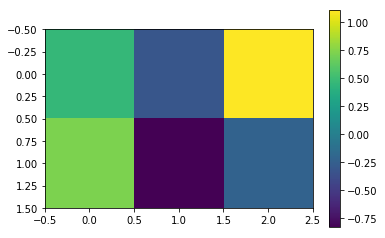

In [9]:
plt.imshow(m.kern.P.value.T)
plt.colorbar()